##### Copyright 2017 Google LLC.

##### Modifications Copyright 2019 Tomoaki Masuda.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.



このノートブックは、以下のノートブックを元に日本語訳、一部章立ての再構成、加筆を行いました。 
https://colab.research.google.com/notebooks/magenta/nsynth/nsynth.ipynb


#  E-Z NSynthでまだ聴いたことのない楽器の音を作る

**WaveNetオートエンコーダによるニューラルオーディオ合成、ICML 2017** 

Jesse Engel、Cinjon Resnick、Adam Roberts、Sander Dieleman、Douglas Eck、Karen Simonyan、Mohammad Norouzi 

## 説明

- このノートブックには、手元のサウンドをアップロードし、NSynthモデルを使って、それらを再構築したり補間するために必要なものがすべて揃っています
- これらのサウンドは[Andrew Huang Rocking Out with NSynth](https://www.youtube.com/watch?v=AaALLWQmCdI)のように、みなさん独自の音楽の音素材として使えます 
- ドロップダウンメニューから**編集&gt;&gt;ノートブック設定&gt;&gt;ハードウェアアクセラレータ&gt;&gt; GPU**を選択し、GPUが有効化されたカーネルを必ず使ってください 
- このノートブックは、コードを書いたり見たりしなくても実行できます。各セルの左側にある三角の **「再生」** ボタンをクリックするだけです
- 一番上から始め、順番に下へ進み、各セルの **「再生」** をクリックします
- コードを見たい場合は、各セルの右上のメニューから表示できます

### その他の資料

* [Nat and Friends "Behind the scenes"](https://www.youtube.com/watch?v=BOoSy-Pg8is)
* [Original Blog Post](https://magenta.tensorflow.org/nsynth)
* [NSynth Instrument](https://magenta.tensorflow.org/nsynth-instrument)
* [Jupyter Notebook Tutorial](https://magenta.tensorflow.org/nsynth-fastgen)
* [ArXiv Paper](https://arxiv.org/abs/1704.01279)
* [Github Code](https://github.com/tensorflow/magenta/tree/master/magenta/models/nsynth)




## A. 環境を準備する

はじめに、事前学習済みNSynthモデルをダウンロード・選択します。数GBを転送するため、1-2分かかるかもしれません。 次のセルの **「再生」** マークをクリックしてください。


In [ ]:
#@title Setup Environment
#@test {"output": "ignore"}


# Install magenta
print('Installing Magenta...\n')
!pip install -q magenta
print('Installing ffmpeg...\n')
!echo "Yes" | apt-get install ffmpeg > /dev/null


print('Downloading Pretrained Models...\n')
# Copy checkpoints from google cloud
# Copying 1GB, takes a minute
print('Getting Instruments Model...\n')
!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar /content/
print('Getting Voices Model...\n')
!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/nsynth/wavenet-voice-ckpt.tar.gz /content/
!cd /content/
!tar -xvf wavenet-ckpt.tar > /dev/null
!tar -xvf wavenet-voice-ckpt.tar.gz > /dev/null


print('Importing Modules...\n')
# Load modules and helper functions
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline

from google.colab import files
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen
from magenta.music.notebook_utils import colab_play as play

def upload(sample_length, sr):
  '''Upload a .wav file.'''
  filemap = files.upload()
  file_list, audio_list = [], []
  for key, value in filemap.iteritems():
    fname = os.path.join('/content/', key)
    with open(fname, 'w') as f:
      f.write(value)
    audio = utils.load_audio(fname, sample_length=sample_length, sr=sr)
    file_list.append(fname)
    audio_list.append(audio)
  return file_list, audio_list

download = files.download

get_name = lambda f: os.path.splitext(os.path.basename(f))[0]

print('Sucess!! Environment is now setup.')


Installing Magenta...

/bin/sh: pip: command not found
Installing ffmpeg...

/bin/sh: apt-get: command not found

Getting Instruments Model...

/bin/sh: gsutil: command not found
Getting Voices Model...

/bin/sh: gsutil: command not found
/bin/sh: line 0: cd: /content/: No such file or directory
tar: wavenet-ckpt.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
tar: wavenet-voice-ckpt.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
Importing Modules...



ImportError: ignored


2つの学習済みモデルから選べます。

- 1つは[NSynth Dataset](https://magenta.tensorflow.org/datasets/nsynth)の個々の楽器ノート（ "Instruments"）で学習したものです
- もう1つはアートプロジェクトのための野生の様々な声（ "Voices"、歌声と話すの混合）で学習しました

Instrumentsモデルはより大量のデータセットで学習しているため、少し汎化性能が高いようです。どちらも完璧に音を再構築できるわけではありませんが、どちらも独特の特徴をサウンドに付加してくれます。どちらが好みか、両方試してみてください！ 


In [ ]:
#@title Choose a Model { vertical-output: true, run: "auto" }
Model = "Instruments" #@param ["Instruments", "Voices"] {type:"string"}
ckpts = {'Instruments': '/content/wavenet-ckpt/model.ckpt-200000',
         'Voices': '/content/wavenet-voice-ckpt/model.ckpt-200000'}

ckpt_path = ckpts[Model]
print('Using model pretrained on %s.' % Model)

Using model pretrained on Instruments.



## B. データセットを読み込む

さて、いよいよ、あなたの準備したサウンドファイルを読み込みます。 `.wav`, `.mp3`ファイルいずれかを使えます。どちらも`.wav`に変換されます。すべてのファイルは、モデルへの入出力用に、16kHzへダウンサンプリングされ、`Length` 秒の長さに合うよう、トリミングまたは無音で埋められます。 

手元にサウンドファイルがありませんか？freesound.orgから無料でサウンドをダウンロードできます。例えば以下があります：
-  [https://freesound.org/people/MustardPlug/sounds/395058/](https://freesound.org/people/MustardPlug/sounds/395058/) 
-  [https://freesound.org/people/cms4f/sounds/159119/](https://freesound.org/people/cms4f/sounds/159119/) 
-  [https://freesound.org/people/juskiddink/sounds/60055/](https://freesound.org/people/juskiddink/sounds/60055/) 
-  [https://freesound.org/people/Audeption/sounds/418526/](https://freesound.org/people/Audeption/sounds/418526/) 
-  [https://freesound.org/people/Jagadamba/sounds/255878/](https://freesound.org/people/Jagadamba/sounds/255878/) 

クラウドGPUを使うと、 音の合成には、1秒の長さあたり、約4分かかります。覚えておいてください。


In [ ]:
#@title Set Sound Length (in Seconds) { vertical-output: true, run: "auto" }
Length = 2.0 #@param {type:"number"}
SR = 16000
SAMPLE_LENGTH = int(SR * Length)


`ファイル選択` から、ローカルのファイルをアップロードします。すべてのサウンドファイルを1つのフォルダに入れ、再構築/補間したいすべてのファイルを必ず選択してください。 **（Ctrl / Cmd / Shiftクリック）** 


In [ ]:
#@title Upload sound files (.wav, .mp3)

try:
  file_list, audio_list = upload(sample_length=SAMPLE_LENGTH, sr=SR)
  names = [get_name(f) for f in file_list]
  # Pad and peak normalize
  for i in range(len(audio_list)):
    audio_list[i] = audio_list[i] / np.abs(audio_list[i]).max()

    if len(audio_list[i]) < SAMPLE_LENGTH:
      padding = SAMPLE_LENGTH - len(audio_list[i])
      audio_list[i] = np.pad(audio_list[i], (0, padding), 'constant')

  audio_list = np.array(audio_list)
except Exception as e:
  print('Upload Cancelled')
  print(e)


## C. データセットを前処理する

次に、オーディオをエンコードする必要があります。これはGPU上では比較的速いはずです。オーディオを再合成するための補間（各エンコードの中間点）も作成します。 


In [ ]:
#@title Generate Encodings
audio = np.array(audio_list)
z = fastgen.encode(audio, ckpt_path, SAMPLE_LENGTH)
print('Encoded %d files' % z.shape[0])


# Start with reconstructions
z_list = [z_ for z_ in z]
name_list = ['recon_' + name_ for name_ in names]

# Add all the mean interpolations
n = len(names)
for i in range(n - 1):
  for j in range(i + 1, n):
    new_z = (z[i] + z[j]) / 2.0
    new_name = 'interp_' + names[i] + '_X_'+ names[j]
    z_list.append(new_z)
    name_list.append(new_name)

print("%d total: %d reconstructions and %d interpolations" % (len(name_list), n, len(name_list) - n))

INFO:tensorflow:Restoring parameters from /content/wavenet-ckpt/model.ckpt-200000
Encoded 5 files
15 total: 5 reconstructions and 10 interpolations



面白いので、オーディオファイルのエンコーディングを見てみましょう。それらはオーディオの圧縮表現ですが、それ自体が何らかの構造を持っています（16の数字、16チャンネルのオーディオのようなもので、16の異なる行があります。色は任意です）。 


395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm


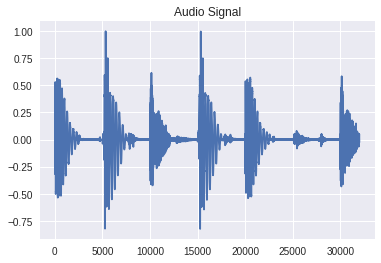

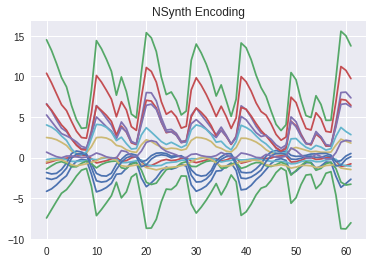

In [ ]:
#@title Visualize Audio and Encoding { vertical-output: true, run: "auto" }
SoundFile = 0 #@param {type:"slider", min:0, max:10, step:1}
file_number = SoundFile

try:
  print(names[file_number])
  play(audio_list[file_number], sample_rate=SR)
  # fig, axs = plt.subplots(2, 1, figsize=(12, 10))
  plt.figure()
  plt.plot(audio_list[file_number])
  plt.title('Audio Signal')

  plt.figure()
  plt.plot(z_list[file_number])
  plt.title('NSynth Encoding')
except Exception as e:
  print e


## D. モデルを取得する

`環境を準備する` にて、既にモデルを取得済みです。


## E. モデルを学習させる

学習済みモデルを使うため不要です。



## F. 学習済みモデルを評価する



### 1. 音を合成する

 GPUでは、1秒のオーディオで、1バッチあたり約4分かかります。 


In [ ]:
#@title Synthesize Interpolations
print('Total Iterations to Complete: %d\n' % SAMPLE_LENGTH)

encodings = np.array(z_list)
save_paths = ['/content/' + name + '.wav' for name in name_list]
fastgen.synthesize(encodings,
                   save_paths=save_paths,
                   checkpoint_path=ckpt_path,
                   samples_per_save=int(SAMPLE_LENGTH / 10))

Total Iterations to Complete: 32000

INFO:tensorflow:Restoring parameters from /content/wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: /content/recon_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm.wav
INFO:tensorflow:Saving: /content/recon_159119__cms4f__flute-play-c-04.wav
INFO:tensorflow:Saving: /content/recon_255878__jagadamba__female-voice-whispering-lab-geaks.wav
INFO:tensorflow:Saving: /content/recon_60055__juskiddink__cello-loop-2.wav
INFO:tensorflow:Saving: /content/recon_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long.wav
INFO:tensorflow:Saving: /content/interp_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm_X_159119__cms4f__flute-play-c-04.wav
INFO:tensorflow:Saving: /content/interp_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm_X_255878__jagadamba__female-voice-whispering-lab-geaks.wav
INFO:tensorflow:Saving: /content/interp_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm_X_60055__juskiddink__cello-loop-2.wav

### 2. 合成した音をダウンロードする

In [ ]:
#@title Download Interpolations
for fname in save_paths:
  print('Downloading: %s' % fname.split('/')[-1])
  download(fname)

Downloading: recon_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm.wav
Downloading: recon_159119__cms4f__flute-play-c-04.wav
Downloading: recon_255878__jagadamba__female-voice-whispering-lab-geaks.wav
Downloading: recon_60055__juskiddink__cello-loop-2.wav
Downloading: recon_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long.wav
Downloading: interp_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm_X_159119__cms4f__flute-play-c-04.wav
Downloading: interp_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm_X_255878__jagadamba__female-voice-whispering-lab-geaks.wav
Downloading: interp_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm_X_60055__juskiddink__cello-loop-2.wav
Downloading: interp_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm_X_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long.wav
Downloading: interp_159119__cms4f__flute-play-c-04_X_255878__jagadamba__female-voice-whispering-lab-geaks.wav
Downloading: interp_159119__cms4f__flute-play-c-04_X_

### 3. 合成した音を聴いてみる

In [ ]:
#@title Listen to the outputs

print("Originals:\n")
for fname in file_list:
  synth_audio = utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR)
  print(get_name(fname))
  play(synth_audio, sample_rate=SR)

for i, fname in enumerate(save_paths):
  if i == 0:
    print("Reconstructions:\n")
  if i == len(file_list):
    print("Interpolations:\n")
  synth_audio = utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR)
  print(get_name(fname))
  play(synth_audio, sample_rate=SR)

Originals:

395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm


159119__cms4f__flute-play-c-04


255878__jagadamba__female-voice-whispering-lab-geaks


60055__juskiddink__cello-loop-2


418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long


Reconstructions:

recon_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm


recon_159119__cms4f__flute-play-c-04


recon_255878__jagadamba__female-voice-whispering-lab-geaks


recon_60055__juskiddink__cello-loop-2


recon_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long


Interpolations:

interp_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm_X_159119__cms4f__flute-play-c-04


interp_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm_X_255878__jagadamba__female-voice-whispering-lab-geaks


interp_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm_X_60055__juskiddink__cello-loop-2


interp_395058__mustardplug__breakbeat-hiphop-a4-4bar-96bpm_X_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long


interp_159119__cms4f__flute-play-c-04_X_255878__jagadamba__female-voice-whispering-lab-geaks


interp_159119__cms4f__flute-play-c-04_X_60055__juskiddink__cello-loop-2


interp_159119__cms4f__flute-play-c-04_X_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long


interp_255878__jagadamba__female-voice-whispering-lab-geaks_X_60055__juskiddink__cello-loop-2


interp_255878__jagadamba__female-voice-whispering-lab-geaks_X_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long


interp_60055__juskiddink__cello-loop-2_X_418526__audeption__fasching-fanfare-karnevals-tusch-tataa-long
